In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv


In [2]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import packages
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly as plotly               
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,recall_score, f1_score, precision_score
from yellowbrick.classifier import ConfusionMatrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.svm import SVC
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
init_notebook_mode(connected=True)
%matplotlib inline

In [4]:
df = pd.read_csv('../input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


The data does not have null data. And this is a classification task to predict whether a person willing to churn for credit card or a loan.

Drop unrelated column named customer_id

In [6]:
df.drop('customer_id',axis=1,inplace=True)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


Draw a heatmap to show the relationship with different variables

In [8]:
df.nunique()

credit_score         460
country                3
gender                 2
age                   70
tenure                11
balance             6382
products_number        4
credit_card            2
active_member          2
estimated_salary    9999
churn                  2
dtype: int64

Text(0.5, 1.0, 'Correlation of dataframe variables')

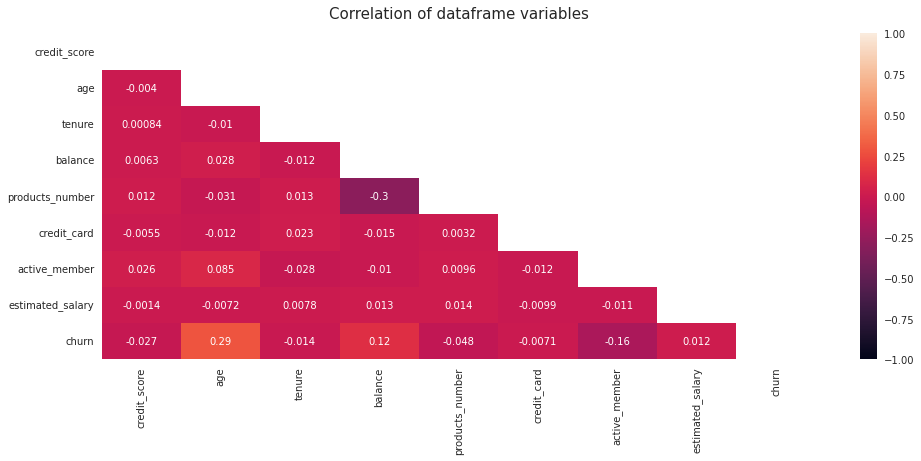

In [9]:
# df.corr()
plt.figure(figsize=(16,6))
# define the mask to set the values in the upper triangle to True
pltgraph = np.triu(np.ones_like(df.corr(), dtype = np.bool))
heatmap_graph = sns.heatmap(df.corr(),mask=pltgraph, vmin=-1, vmax=1, annot=True)
heatmap_graph.set_title('Correlation of dataframe variables', fontdict={'fontsize':15}, pad=15)

Draw distribution between target and input data.

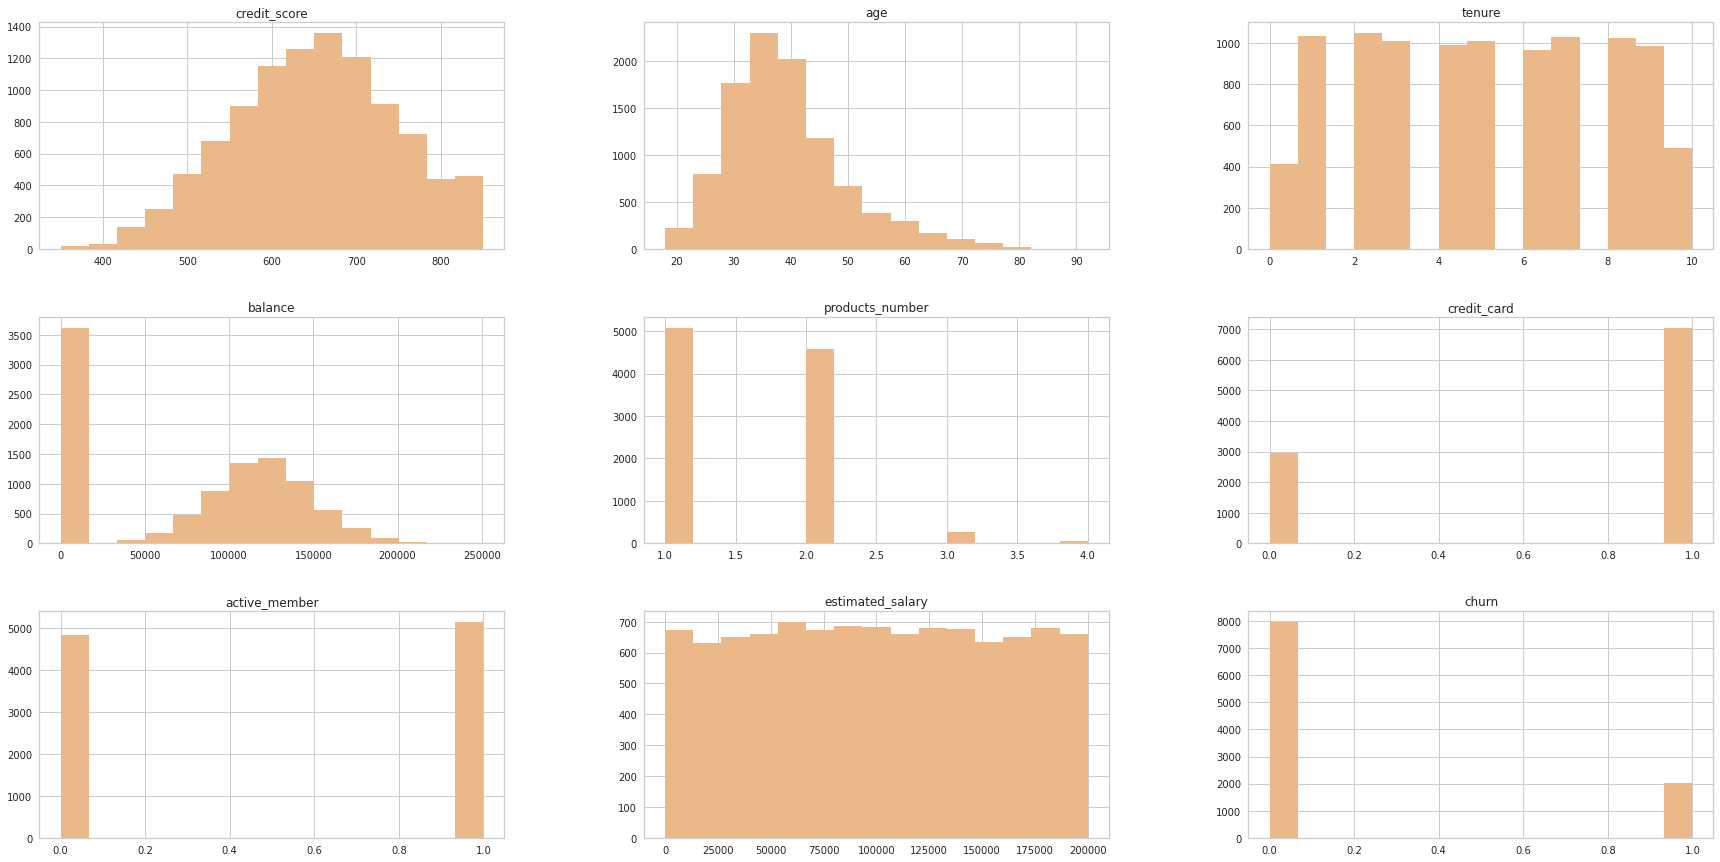

In [10]:
color = '#eab889'
df.hist(bins=15,figsize=(30,15),color=color)
plt.rcParams['font.size'] = 25
plt.show()

In [11]:
# finding null data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


There is not missing data

In [12]:
df['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

The result is balanced, it is a balance dataset.

**Part one: Data Visualization**

Text(0, 0.5, 'Count')

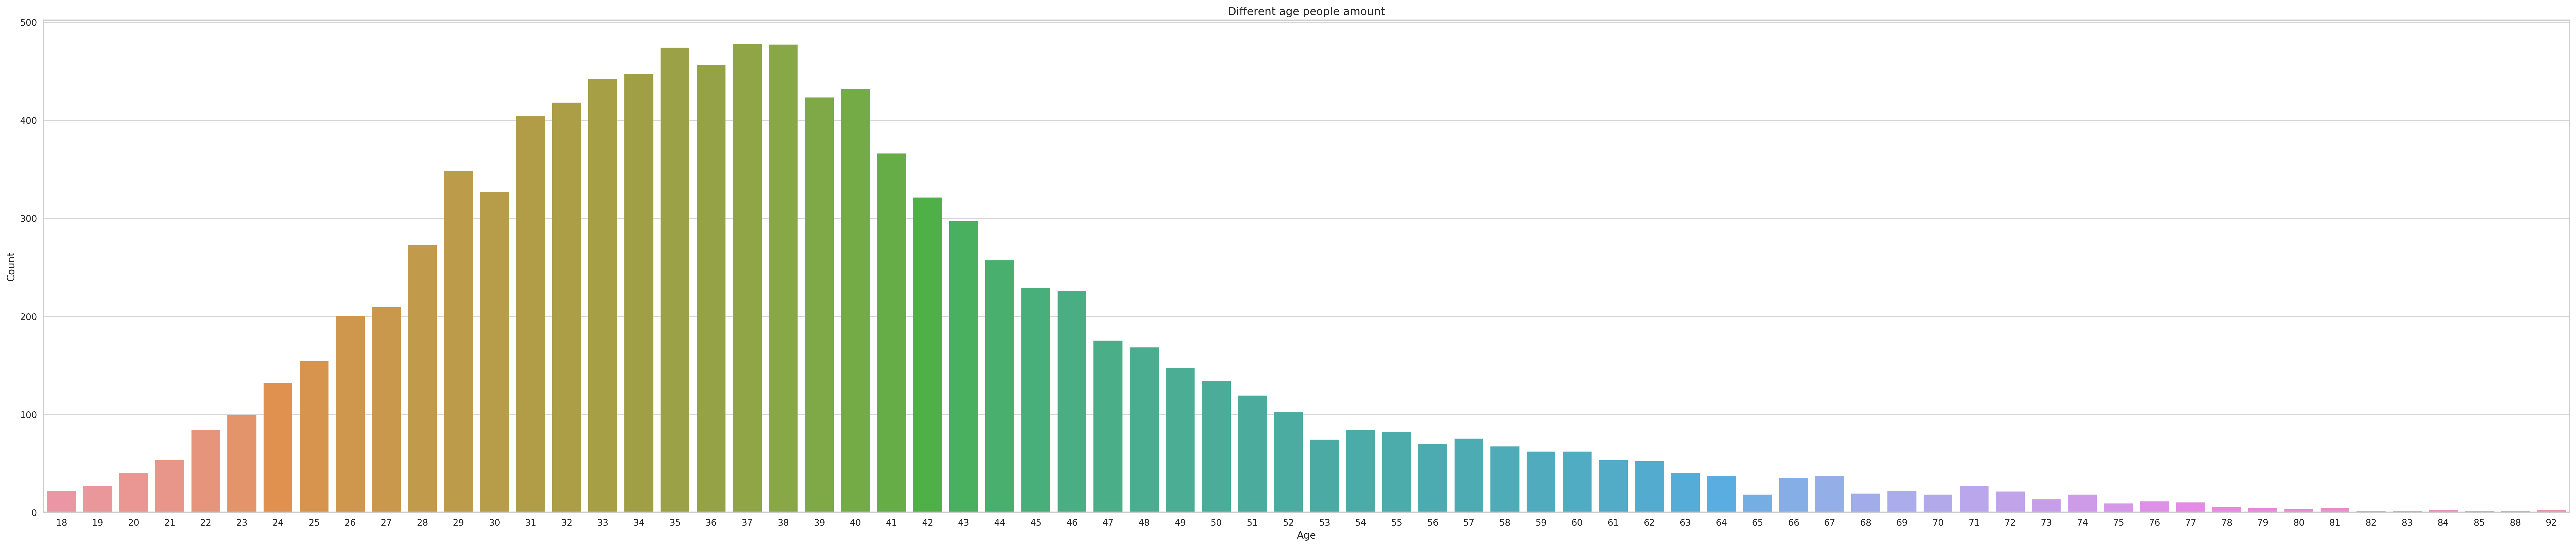

In [13]:
# 1. age distribution 
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.figure(figsize=(50,10),dpi=256)
sns.countplot(x='age',data=df)
plt.title('Different age people amount')
plt.xlabel('Age')
plt.ylabel('Count')

It is easy to see that most people belong to age range between 26 and 50. And it is a left skewed distribution

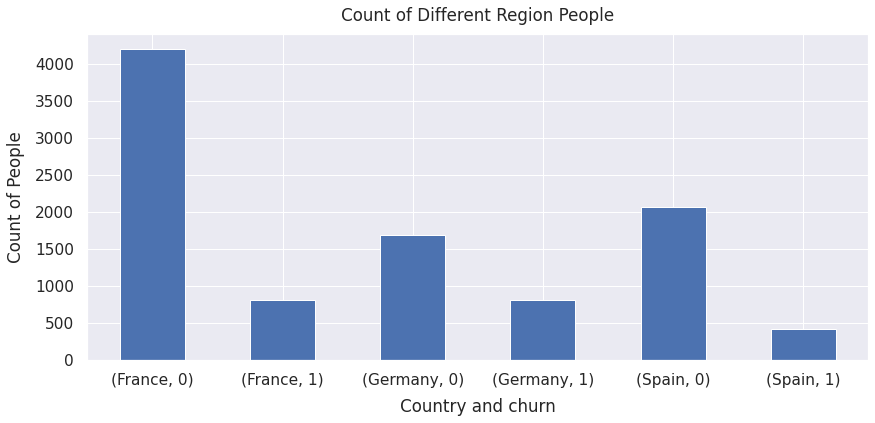

In [14]:
# 2. churn for country
sns.set(font_scale=1.4)
df.groupby('country')['churn'].value_counts().plot(kind='bar', figsize=(14, 6), rot=0)
plt.xlabel("Country and churn", labelpad=10)
plt.ylabel("Count of People", labelpad=10)
plt.title("Count of Different Region People", y=1.02);

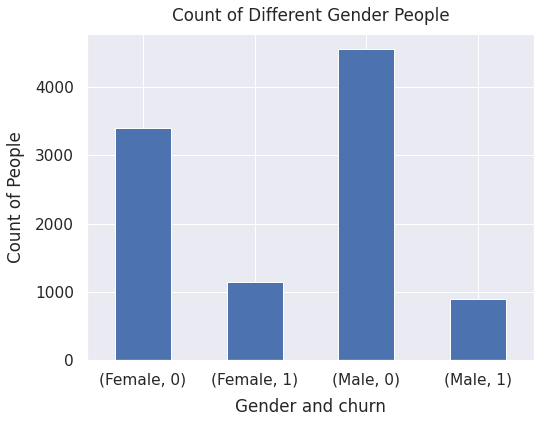

In [15]:
# 3.churn for gender 
sns.set(font_scale=1.4)
df.groupby('gender')['churn'].value_counts().plot(kind='bar', figsize=(8, 6), rot=0)
plt.xlabel("Gender and churn", labelpad=10)
plt.ylabel("Count of People", labelpad=10)
plt.title("Count of Different Gender People", y=1.02);

Text(0, 0.5, 'Active_member')

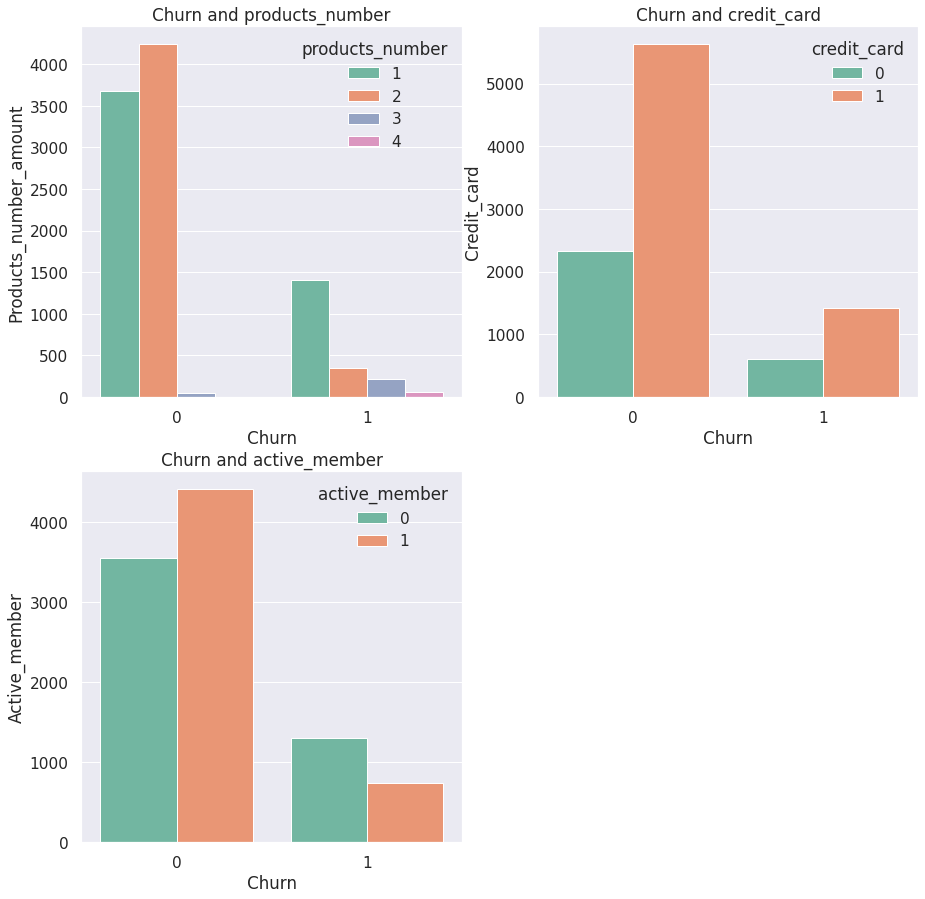

In [16]:
# 4.other variables with target variable
plt.figure(figsize=(15,15)) 

plt.subplot(2,2,1)
sns.countplot(x = 'churn', hue= 'products_number', palette='Set2', data = df)
plt.title('Churn and products_number')
plt.xlabel('Churn')
plt.ylabel('Products_number_amount')

plt.subplot(2,2,2)
sns.countplot(x = 'churn', hue= 'credit_card', palette='Set2', data = df)
plt.title('Churn and credit_card')
plt.xlabel('Churn')
plt.ylabel('Credit_card')

plt.subplot(2,2,3)
sns.countplot(x = 'churn', hue= 'active_member', palette='Set2', data = df)
plt.title('Churn and active_member')
plt.xlabel('Churn')
plt.ylabel('Active_member')

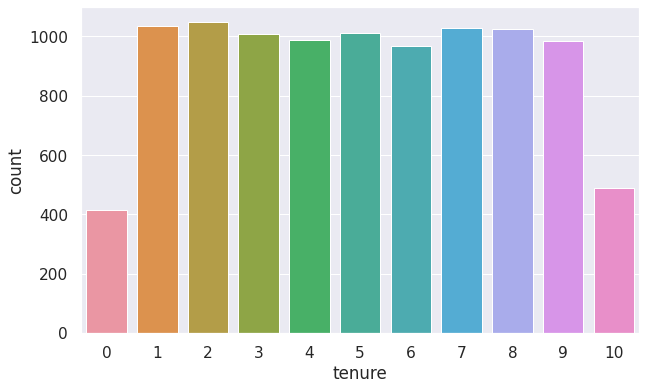

,tenure,churn
0,0,95
1,1,232
2,2,201
3,3,213
4,4,203
5,5,209
6,6,196
7,7,177
8,8,197
9,9,213


In [17]:
# 5.total churn number of each tenure period
df2 = df.groupby("tenure").agg({"churn":"sum"}).reset_index()
plt.figure(figsize=(10,6))
sns.countplot(df["tenure"])
plt.show()
df2

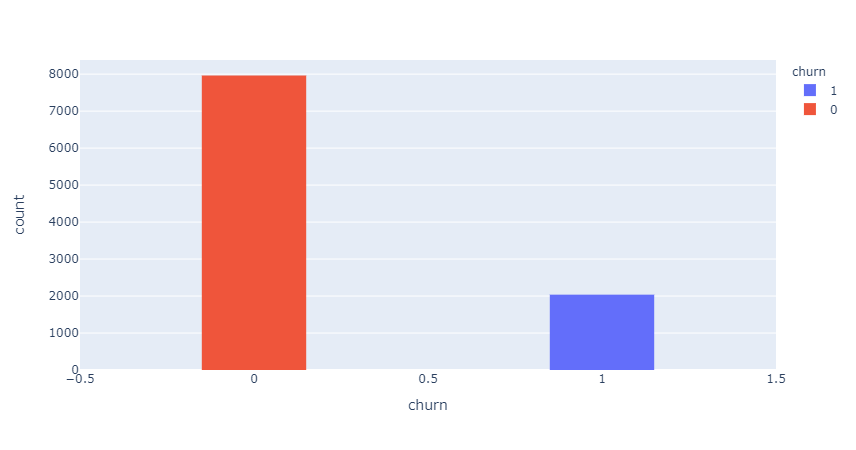

In [18]:
#5.churn

fig = px.histogram(df, x="churn",color="churn")
fig.update_layout(bargap=0.7)
fig.show()

<AxesSubplot:xlabel='estimated_salary', ylabel='Density'>

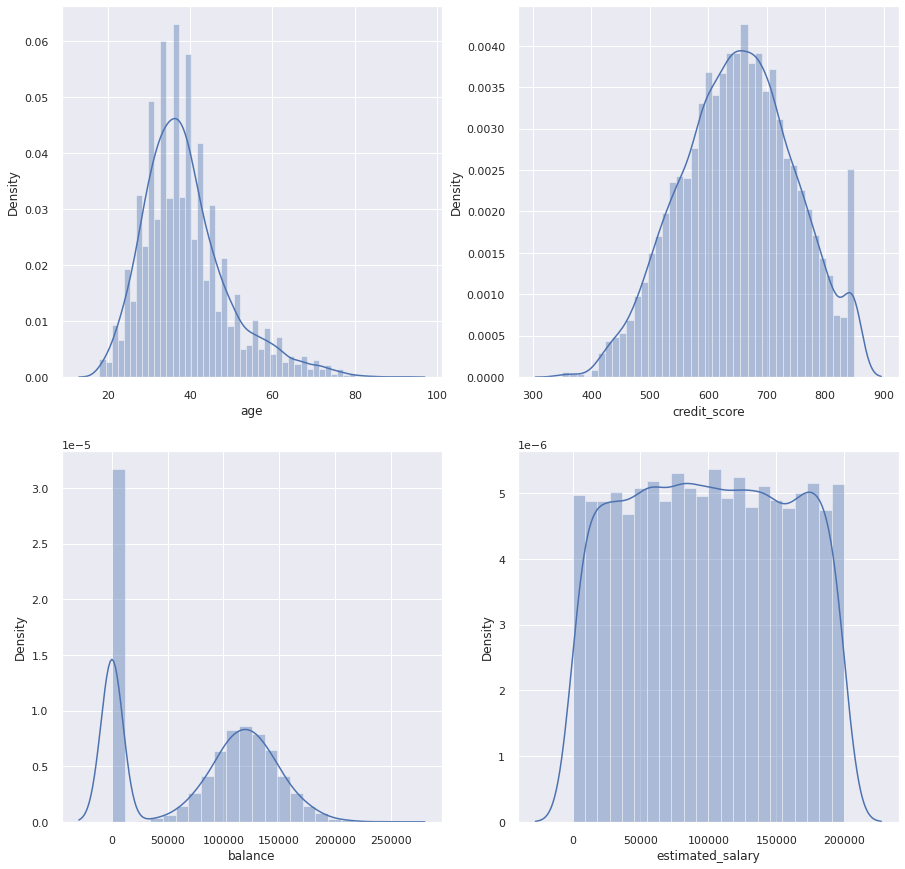

In [19]:
# 6. continuous variables
plt.figure(figsize = (15,15))

sns.set(color_codes = True)

plt.subplot(2,2,1)
sns.distplot(df['age'])

plt.subplot(2,2,2)
sns.distplot(df['credit_score'])

plt.subplot(2,2,3)
sns.distplot(df['balance'])

plt.subplot(2,2,4)
sns.distplot(df['estimated_salary'])

credit_score            AxesSubplot(0.125,0.71587;0.168478x0.16413)
age                  AxesSubplot(0.327174,0.71587;0.168478x0.16413)
tenure               AxesSubplot(0.529348,0.71587;0.168478x0.16413)
balance              AxesSubplot(0.731522,0.71587;0.168478x0.16413)
products_number        AxesSubplot(0.125,0.518913;0.168478x0.16413)
credit_card         AxesSubplot(0.327174,0.518913;0.168478x0.16413)
active_member       AxesSubplot(0.529348,0.518913;0.168478x0.16413)
estimated_salary    AxesSubplot(0.731522,0.518913;0.168478x0.16413)
churn                  AxesSubplot(0.125,0.321957;0.168478x0.16413)
dtype: object

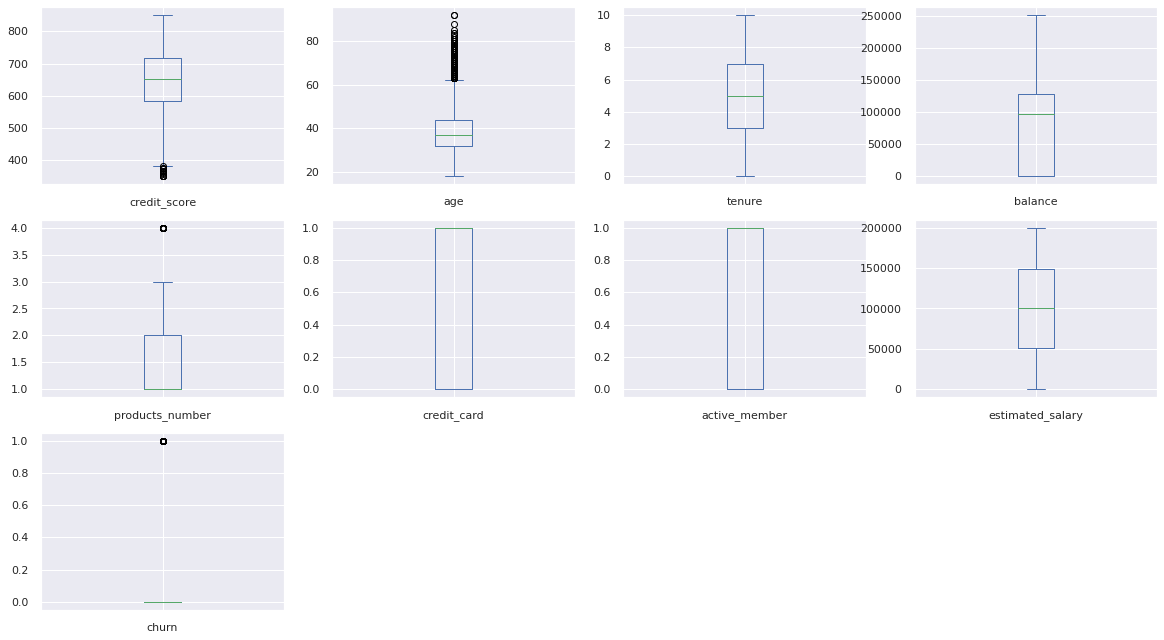

In [20]:
# box plot for each variables
df.plot(subplots=True, kind='box', figsize=(20,15),layout=(4,4))

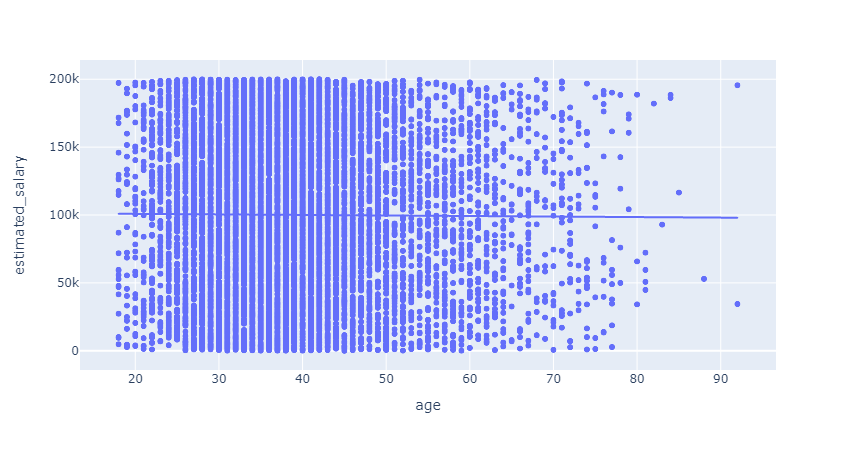

In [21]:
px.scatter(df, x="age",y="estimated_salary",trendline="ols")

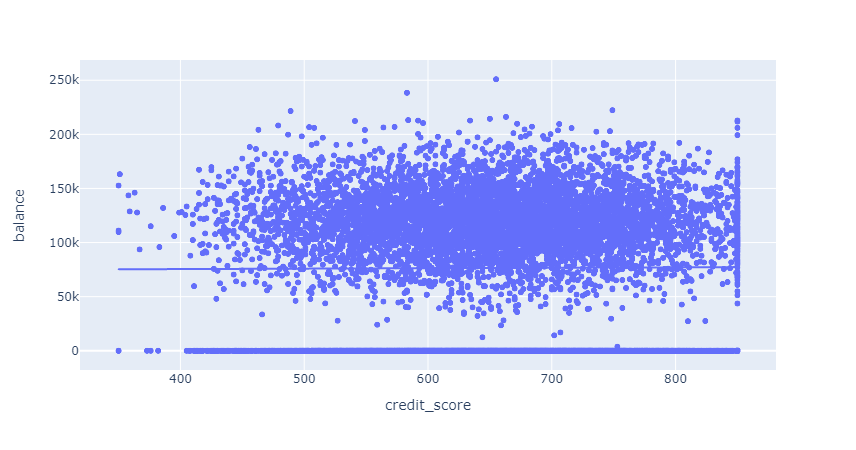

In [22]:
px.scatter(df,x="credit_score",y="balance",trendline="ols")

**Part2 Data preprocessing**

In [23]:
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [24]:
# encoding catrgory variables 
df['country'] = LabelEncoder().fit_transform(df['country'])
df['gender'] = LabelEncoder().fit_transform(df['country'])
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,2,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,2,43,2,125510.82,1,1,1,79084.10,0


this dataframe is a imbalanced example. In the banking business, most of the users have a good reputation, and a few have the risk of default, so I need to balance the data, which can help improve the accuracy of the model.

In [25]:
# divide data into X and y
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X.shape,y.shape

((10000, 10), (10000,))

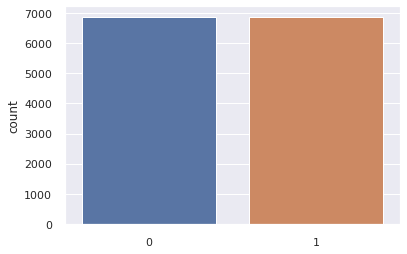

In [26]:
# first attempt to use smote resample method to deal with imbalance
smt = SMOTETomek(random_state=10)
# resample X and y
X, y = smt.fit_resample(X, y)
ax = sns.countplot(y)

Next step is to standardize, standardize data class variables, using the StandardScaler() method

In [27]:
# standardize numeric variables
std = StandardScaler()
# standarize numeric features
X = std.fit_transform(X)
X[1:3]

array([[-0.43749526,  1.62619407,  1.62619407, -0.00828284, -1.45517072,
         0.01932875, -0.83203563, -1.6478148 ,  1.16135334,  0.19232617],
       [ 0.54404568, -1.01024202, -1.01024202, -0.20572442, -1.45517072,
        -1.3429542 ,  0.79533386, -1.6478148 , -0.96346648, -0.13168732]])

From the previous box plot, we can find that outliers appear in credit score and age, but the purpose of our task this time is to classify, so each data point is meaningful, so we will not process outlier values first.

Next step using train_test_split method split X,y into train set and test set

In [52]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9636, 10), (4130, 10), (9636,), (4130,))

**Part 3: Model building**

For this classification question I will apply following algorithms:
1. Naive Bayes
2. Logistic Regression
3. Decision Tree
4. Random Forest
5. XGBoosting
6. GBDT
7. LightGBM
8. SVM
9. DNN
10. Other algoritms comparision

**1. Naive Bayes**

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      2065
           1       0.76      0.75      0.76      2065

    accuracy                           0.76      4130
   macro avg       0.76      0.76      0.76      4130
weighted avg       0.76      0.76      0.76      4130

Accuracy score of Naive Bayes:  0.7605326876513318


0.7605326876513318

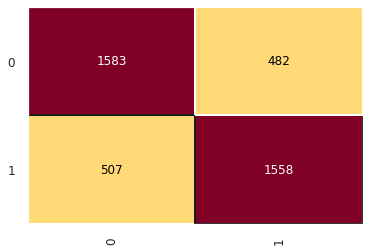

In [30]:
# 1. Naive Bayes
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred_nb = nb.predict(X_test)
print(classification_report(y_test,y_pred_nb,digits=2))
print("Accuracy score of Naive Bayes: ", accuracy_score(y_test, y_pred_nb))
cm = ConfusionMatrix(nb)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
# I use the cross_val_score method to test whether the effect will be better using ten-fold cross-validation

There are very few hyperparameters that can be adjusted by the Naive Bayes method, and most of them are used in NLP, so Gridsearch is not used here to improve accuracy.

In [31]:
kfold = KFold(n_splits=10, shuffle=True)
score = cross_val_score(nb, X_train, y_train, cv=kfold, scoring='accuracy')
score = score.mean()
print(f'10 CV final accuracy score is {score}')

10 CV final accuracy score is 0.763809068307459


**2. Logistic Regression**

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2065
           1       0.70      0.70      0.70      2065

    accuracy                           0.70      4130
   macro avg       0.70      0.70      0.70      4130
weighted avg       0.70      0.70      0.70      4130

Accuracy score of Logistic Regression:  0.7041162227602905


0.7041162227602905

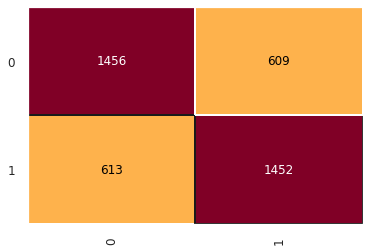

In [32]:
# 2. Logistic Regression
lg = LogisticRegression(random_state=10)
lg.fit(X_train,y_train)
y_pred_lg = lg.predict(X_test)
print(classification_report(y_test,y_pred_lg,digits=2))
print("Accuracy score of Logistic Regression: ", accuracy_score(y_test, y_pred_lg))
cm = ConfusionMatrix(lg)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

Using gridsearchcv find best parameters and rebuild logistic regression model

Best model estimators of logistic regression LogisticRegression(C=0.001, random_state=10)
Best model parameters of logistic regression {'C': 0.001, 'penalty': 'l2'}
Best model parameters of logistic regression 0.702675239606638

----------After GridSearch Model Result-----------
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2065
           1       0.70      0.70      0.70      2065

    accuracy                           0.70      4130
   macro avg       0.70      0.70      0.70      4130
weighted avg       0.70      0.70      0.70      4130

Accuracy score of Logistic Regression:  0.7041162227602905


0.7014527845036319

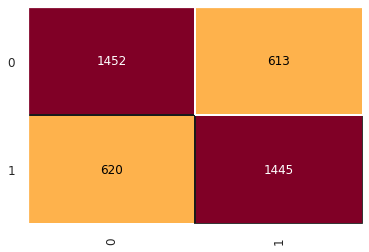

In [33]:
param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
clf = GridSearchCV(lg, param_grid ,cv=5, scoring='accuracy')
clf.fit(X_train,y_train)
print(f'Best model estimators of logistic regression {clf.best_estimator_}')
# clf.cv_results_
print(f'Best model parameters of logistic regression {clf.best_params_}')
print(f'Best model parameters of logistic regression {clf.best_score_}\n')
# applying best parameters into new logistic regression model
print('----------After GridSearch Model Result-----------')
lg_grid = LogisticRegression(penalty='l2' ,C=0.001, random_state=10)
lg_grid.fit(X_train,y_train)
y_pred_lg_grid = lg.predict(X_test)
print(classification_report(y_test,y_pred_lg_grid,digits=2))
print("Accuracy score of Logistic Regression: ", accuracy_score(y_test, y_pred_lg_grid))
cm = ConfusionMatrix(lg_grid)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

In [34]:
kfold = KFold(n_splits=10, shuffle=True)
score = cross_val_score(lg_grid, X_train, y_train, cv=kfold, scoring='accuracy')
score = score.mean()
print(f'10 CV final accuracy score is {score}')

10 CV final accuracy score is 0.7024701292210114


Logistic regression does not perform as well as the previous Naive Bayes, and the grid parameter search does not find the optimal parameters (too few choices, or insufficient previous feature engineering). The performance accuracy is around 0.7.

**3. Decision Tree**

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2065
           1       0.70      0.70      0.70      2065

    accuracy                           0.70      4130
   macro avg       0.70      0.70      0.70      4130
weighted avg       0.70      0.70      0.70      4130

Accuracy score of Decision Tree:  0.7041162227602905


0.8728813559322034

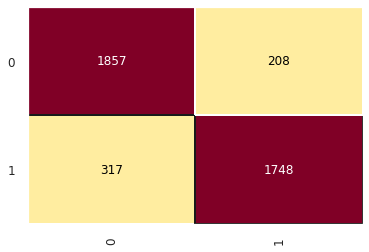

In [35]:
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth= 10, min_samples_split=3,random_state=10)
dt.fit(X_train, y_train)
y_pred_d = lg.predict(X_test)
print(classification_report(y_test,y_pred_d,digits=2))
print("Accuracy score of Decision Tree: ", accuracy_score(y_test, y_pred_d))
cm = ConfusionMatrix(dt)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

In [36]:
# check the importance of features
columns = df.iloc[:,:10].columns
feature_importance = pd.Series(dt.feature_importances_,index=columns).sort_values(ascending=False)
feature_importance

active_member      0.28
products_number    0.26
age                0.24
gender             0.06
balance            0.06
estimated_salary   0.03
credit_score       0.03
country            0.02
tenure             0.01
credit_card        0.01
dtype: float64

According to the decision tree prediction, active_member,products_number and age are relatively important for classifying churn, and other variables are relatively unimportant. And if the decision tree depth is 10 or more, the performance is better than NB and LR, but it may cause overfitting.

In [37]:
# gridsearch best brunched tree
params = {'max_leaf_nodes': list(range(2, 30)), 'min_samples_split': [2, 3, 4], 'criterion':['gini', 'entropy'], 'max_depth':[2,4,6,8,10]}
gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=10), params, verbose=1, cv=3)
gs_dt.fit(X_train,y_train)
print(f'Best model estimators of Decision Tree {gs_dt.best_estimator_}')
# clf.cv_results_
print(f'Best model parameters of Decision Tree {gs_dt.best_params_}')
print(f'Best model parameters of Decision Tree {gs_dt.best_score_}\n')
print('----------After GridSearch Model Result-----------')

Fitting 3 folds for each of 840 candidates, totalling 2520 fits
Best model estimators of Decision Tree DecisionTreeClassifier(max_depth=8, max_leaf_nodes=29, random_state=10)
Best model parameters of Decision Tree {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 29, 'min_samples_split': 2}
Best model parameters of Decision Tree 0.8710045662100456

----------After GridSearch Model Result-----------


              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2065
           1       0.89      0.86      0.87      2065

    accuracy                           0.88      4130
   macro avg       0.88      0.88      0.88      4130
weighted avg       0.88      0.88      0.88      4130

Accuracy score of Logistic Regression:  0.8765133171912833


0.8765133171912833

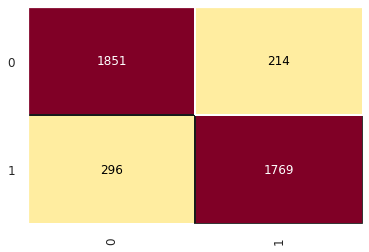

In [38]:
dt_grid = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=29, random_state=10, min_samples_split=2, criterion='gini')
dt_grid.fit(X_train,y_train)
y_pred_dt_grid = dt_grid.predict(X_test)
print(classification_report(y_test,y_pred_dt_grid,digits=2))
print("Accuracy score of Logistic Regression: ", accuracy_score(y_test, y_pred_dt_grid))
cm = ConfusionMatrix(dt_grid)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

It is easy to see that after gridsearch, the performance of decision tree model improved a lot, from 0.7 to 0.88. The best parameters are : 'criterion': 'gini', 'max_depth': 12, 'max_leaf_nodes': 39, 'min_samples_split': 2

**4. Random Forest**

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2065
           1       0.94      0.88      0.91      2065

    accuracy                           0.91      4130
   macro avg       0.91      0.91      0.91      4130
weighted avg       0.91      0.91      0.91      4130

Accuracy score of Decision Tree:  0.9099273607748184


0.9099273607748184

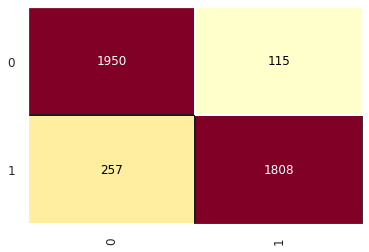

In [39]:
rfc = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, random_state=10)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print(classification_report(y_test,y_pred_rfc,digits=2))
print("Accuracy score of Decision Tree: ", accuracy_score(y_test, y_pred_rfc))
cm = ConfusionMatrix(rfc)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

Random forest performace pretty good in the first time, now i will use gridsearch to make the accuracy better.

In [40]:
param_grid = { 
    'n_estimators': [200, 400],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [5,6,7,8],
    'criterion' :['gini', 'entropy']
}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=10), params, verbose=1, cv=3)
gs_rf.fit(X_train,y_train)
print(f'Best model estimators of Raddom Forest {gs_rf.best_estimator_}')
# clf.cv_results_
print(f'Best model parameters of Raddom Forest {gs_rf.best_params_}')
print(f'Best model parameters of Raddom Forest {gs_rf.best_score_}\n')
print('----------After GridSearch Model Result-----------')

Fitting 3 folds for each of 840 candidates, totalling 2520 fits
Best model estimators of Raddom Forest RandomForestClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=29,
                       random_state=10)
Best model parameters of Raddom Forest {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 29, 'min_samples_split': 2}
Best model parameters of Raddom Forest 0.8851183063511829

----------After GridSearch Model Result-----------


              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2065
           1       0.92      0.85      0.88      2065

    accuracy                           0.89      4130
   macro avg       0.89      0.89      0.89      4130
weighted avg       0.89      0.89      0.89      4130

Accuracy score of Logistic Regression:  0.8861985472154964


0.8861985472154964

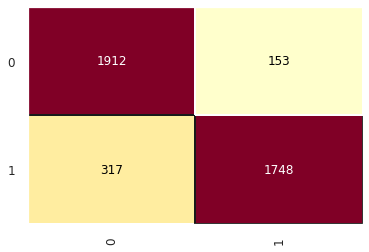

In [41]:
rf_grid = RandomForestClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=39,
                       min_samples_split=4, random_state=10)
rf_grid.fit(X_train,y_train)
y_pred_rf_grid = rf_grid.predict(X_test)
print(classification_report(y_test,y_pred_rf_grid,digits=2))
print("Accuracy score of Logistic Regression: ", accuracy_score(y_test, y_pred_rf_grid))
cm = ConfusionMatrix(rf_grid)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

5. XGBoosting

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2065
           1       0.93      0.88      0.90      2065

    accuracy                           0.91      4130
   macro avg       0.91      0.91      0.91      4130
weighted avg       0.91      0.91      0.91      4130

Accuracy score of Decision Tree:  0.9060532687651331


0.9060532687651331

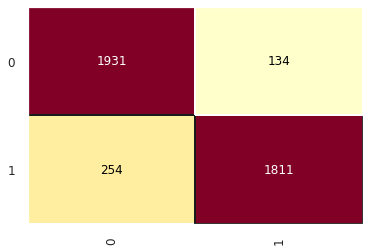

In [42]:
import xgboost as xgb
# binary classification
xgb2 = xgb.XGBClassifier(objective="binary:logistic", random_state=10)
xgb2.fit(X_train, y_train)
y_pred_xgb = xgb2.predict(X_test)
print(classification_report(y_test,y_pred_xgb,digits=2))
print("Accuracy score of Decision Tree: ", accuracy_score(y_test, y_pred_xgb))
cm = ConfusionMatrix(xgb2)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

In [43]:
from scipy.stats import uniform, randint

params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6), 
    "n_estimators": randint(100, 150), 
    "subsample": uniform(0.6, 0.4)
}

xgb_grid = RandomizedSearchCV(xgb2, param_distributions=params, random_state=10, n_iter=200, cv=3, verbose=1,return_train_score=True)
xgb_grid.fit(X_train, y_train)
print(f'Best model estimators of XGB {xgb_grid.best_estimator_}')
# clf.cv_results_
print(f'Best model parameters of XGB {xgb_grid.best_params_}')
print(f'Best model parameters of XGB {xgb_grid.best_score_}\n')
print('----------After GridSearch Model Result-----------')

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best model estimators of XGB XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.40679132355585884, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.13771851397517365,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=106, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, ...)
Best model parameters of XGB {'gamma': 0.40679132355585884, 'learning_rate': 0.13771851397517365, 'max_depth': 5, 'n_estimators': 106, 'subsample': 0.9913668007141632}


The accuracy score of gridsearch XGB model is 0.9088

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2065
           1       0.94      0.87      0.91      2065

    accuracy                           0.91      4130
   macro avg       0.91      0.91      0.91      4130
weighted avg       0.91      0.91      0.91      4130

Accuracy score of Logistic Regression:  0.9094430992736078


0.9094430992736078

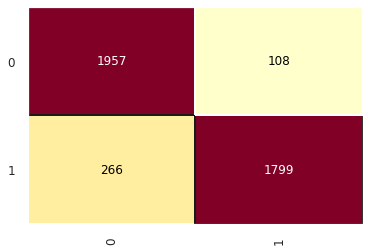

In [44]:
# build best model
xgb_after = xgb.XGBClassifier(gamma= 0.4068, learning_rate= 0.13771851397517365, max_depth =5,
                          n_estimators= 106, subsample= 0.9913668007141632)
xgb_after.fit(X_train,y_train)
y_pred_xgb_grid = xgb_after.predict(X_test)
print(classification_report(y_test,y_pred_xgb_grid,digits=2))
print("Accuracy score of Logistic Regression: ", accuracy_score(y_test, y_pred_xgb_grid))
cm = ConfusionMatrix(xgb_after)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

6.GBDT

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2065
           1       0.90      0.82      0.86      2065

    accuracy                           0.87      4130
   macro avg       0.87      0.87      0.87      4130
weighted avg       0.87      0.87      0.87      4130

Accuracy score of Decision Tree:  0.8663438256658595


0.8663438256658595

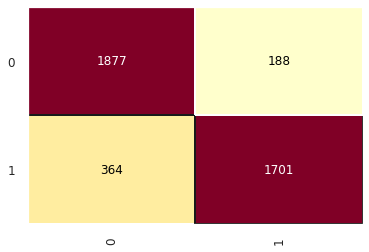

In [45]:
gbc = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, 
                                 max_features=2, max_depth = 2, random_state = 10)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
print(classification_report(y_test,y_pred_gbc,digits=2))
print("Accuracy score of Decision Tree: ", accuracy_score(y_test, y_pred_gbc))
cm = ConfusionMatrix(gbc)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

In [46]:
# params = {
#     "learning_rate": [0.01,0.02,0.1,0.25,0.5,0.75,1]
# }
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

gbc_grid = RandomizedSearchCV(gbc, param_distributions=parameters, random_state=10, n_iter=200, cv=10, verbose=1,return_train_score=True)
gbc_grid.fit(X_train, y_train)
print(f'Best model estimators of XGB {gbc_grid.best_estimator_}')
# clf.cv_results_
print(f'Best model parameters of XGB {gbc_grid.best_params_}')
print(f'Best model parameters of XGB {gbc_grid.best_score_}\n')
print('----------After GridSearch Model Result-----------')

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best model estimators of XGB GradientBoostingClassifier(learning_rate=0.15, max_depth=5, max_features='log2',
                           min_samples_leaf=0.1,
                           min_samples_split=0.24545454545454548,
                           n_estimators=10, random_state=10, subsample=0.95)
Best model parameters of XGB {'subsample': 0.95, 'n_estimators': 10, 'min_samples_split': 0.24545454545454548, 'min_samples_leaf': 0.1, 'max_features': 'log2', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.15, 'criterion': 'friedman_mse'}
Best model parameters of XGB 0.8333327947329188

----------After GridSearch Model Result-----------


              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2065
           1       0.94      0.87      0.91      2065

    accuracy                           0.91      4130
   macro avg       0.91      0.91      0.91      4130
weighted avg       0.91      0.91      0.91      4130

Accuracy score of Logistic Regression:  0.9094430992736078


0.8283292978208232

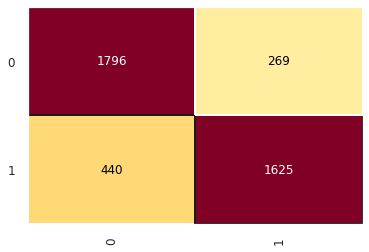

In [47]:
gbc_after = GradientBoostingClassifier(learning_rate=0.15, max_depth=5, max_features='log2',
                           min_samples_leaf=0.1,
                           min_samples_split=0.24545454545454548,
                           n_estimators=10, random_state=10, subsample=0.95)
gbc_after.fit(X_train,y_train)
y_pred_gbc_grid = xgb_after.predict(X_test)
print(classification_report(y_test,y_pred_gbc_grid,digits=2))
print("Accuracy score of Logistic Regression: ", accuracy_score(y_test, y_pred_gbc_grid))
cm = ConfusionMatrix(gbc_after)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

7.Lightbgm

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2065
           1       0.95      0.87      0.91      2065

    accuracy                           0.91      4130
   macro avg       0.91      0.91      0.91      4130
weighted avg       0.91      0.91      0.91      4130

Accuracy score of Decision Tree:  0.9099273607748184


0.9099273607748184

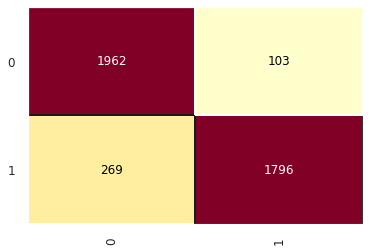

In [48]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)
print(classification_report(y_test,y_pred_lgb,digits=2))
print("Accuracy score of Decision Tree: ", accuracy_score(y_test, y_pred_lgb))
cm = ConfusionMatrix(lgb)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

In [49]:
gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24,32],
    'num_leaves': [8,12,16], 
    'boosting_type' : ['gbdt', 'dart'], 
    'max_bin':[255, 510], 
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2]
    }

grid = GridSearchCV(lgb, gridParams, verbose=1, cv=3, n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 24, 'num_leaves': 16, 'random_state': 10, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.852428393524284


              precision    recall  f1-score   support

           0       0.84      0.89      0.87      2065
           1       0.89      0.83      0.86      2065

    accuracy                           0.86      4130
   macro avg       0.86      0.86      0.86      4130
weighted avg       0.86      0.86      0.86      4130

Accuracy score of Logistic Regression:  0.8610169491525423


0.8610169491525423

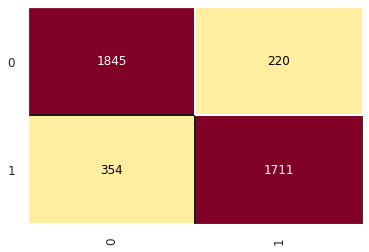

In [50]:
new_model = LGBMClassifier(boosting_type = 'gbdt', learning_rate = 0.01, max_bin = 255, n_estimators = 24, 
                           num_leaves=16,random_state=10, reg_alpha=1,reg_lambda=1, subsample=0.7)
new_model.fit(X_train,y_train)
y_pred_lgb_grid = new_model.predict(X_test)
print(classification_report(y_test,y_pred_lgb_grid,digits=2))
print("Accuracy score of Logistic Regression: ", accuracy_score(y_test, y_pred_lgb_grid))
cm = ConfusionMatrix(new_model)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

8.SVM

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      2065
           1       0.86      0.81      0.84      2065

    accuracy                           0.84      4130
   macro avg       0.84      0.84      0.84      4130
weighted avg       0.84      0.84      0.84      4130

Accuracy score of Decision Tree:  0.8409200968523003


0.8409200968523003

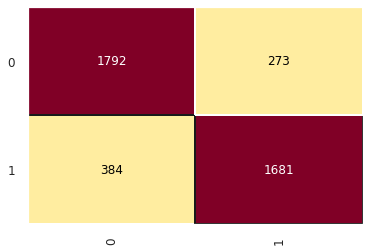

In [51]:
svm = SVC()
svm.fit(X_train,y_train)
y_pred_svm = svm.predict(X_test)
print(classification_report(y_test,y_pred_svm,digits=2))
print("Accuracy score of Decision Tree: ", accuracy_score(y_test, y_pred_svm))
cm = ConfusionMatrix(svm)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

9.DNN

In [51]:
early_stopping = EarlyStopping(
    patience=15,
    min_delta=0.004, 
    restore_best_weights=True)

model = Sequential()
# layer1
model.add(Dense(units=10,kernel_initializer = 'uniform', activation='selu',kernel_regularizer=regularizers.L2(0.001)))
keras.layers.BatchNormalization()
# layer2
model.add(Dense(units=360, activation='relu',kernel_regularizer=regularizers.L2(0.0001)))
keras.layers.BatchNormalization()
#layer3
model.add(Dense(units=100, activation='relu',kernel_regularizer=regularizers.L2(0.0001)))
keras.layers.BatchNormalization()
#layer4
model.add(Dense(units=50, activation='relu',kernel_regularizer=regularizers.L2(0.0001)))
keras.layers.BatchNormalization()

model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 10, epochs = 150,callbacks=[early_stopping], validation_split=0.3)

Epoch 1/150
675/675 [==============================] - 3s 4ms/step - loss: 0.5578 - accuracy: 0.7331 - val_loss: 0.4857 - val_accuracy: 0.7890
Epoch 2/150
675/675 [==============================] - 2s 3ms/step - loss: 0.4654 - accuracy: 0.7911 - val_loss: 0.4229 - val_accuracy: 0.8205
Epoch 3/150
675/675 [==============================] - 2s 3ms/step - loss: 0.4377 - accuracy: 0.8052 - val_loss: 0.4300 - val_accuracy: 0.8077
Epoch 4/150
675/675 [==============================] - 2s 3ms/step - loss: 0.4205 - accuracy: 0.8133 - val_loss: 0.4191 - val_accuracy: 0.8229
Epoch 5/150
675/675 [==============================] - 2s 4ms/step - loss: 0.4050 - accuracy: 0.8224 - val_loss: 0.3927 - val_accuracy: 0.8388
Epoch 6/150
675/675 [==============================] - 2s 3ms/step - loss: 0.3935 - accuracy: 0.8297 - val_loss: 0.3854 - val_accuracy: 0.8430
Epoch 7/150
675/675 [==============================] - 3s 4ms/step - loss: 0.3845 - accuracy: 0.8345 - val_loss: 0.3776 - val_accuracy: 0.8502

10.Lazyclassifer

In [33]:
clf = LazyClassifier(ignore_warnings = True, classifiers = 'all', custom_metric= None)
results,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(results)

100%|██████████| 29/29 [00:29<00:00,  1.03s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.91               0.91     0.91      0.91   
ExtraTreesClassifier               0.91               0.91     0.91      0.91   
RandomForestClassifier             0.91               0.91     0.91      0.91   
XGBClassifier                      0.91               0.91     0.91      0.91   
BaggingClassifier                  0.89               0.89     0.89      0.89   
AdaBoostClassifier                 0.89               0.89     0.89      0.89   
DecisionTreeClassifier             0.86               0.86     0.86      0.86   
LabelSpreading                     0.85               0.85     0.85      0.85   
LabelPropagation                   0.85               0.85     0.85      0.85   
ExtraTreeClassifier                0.85               0.85     0.85      0.85   
SVC                         

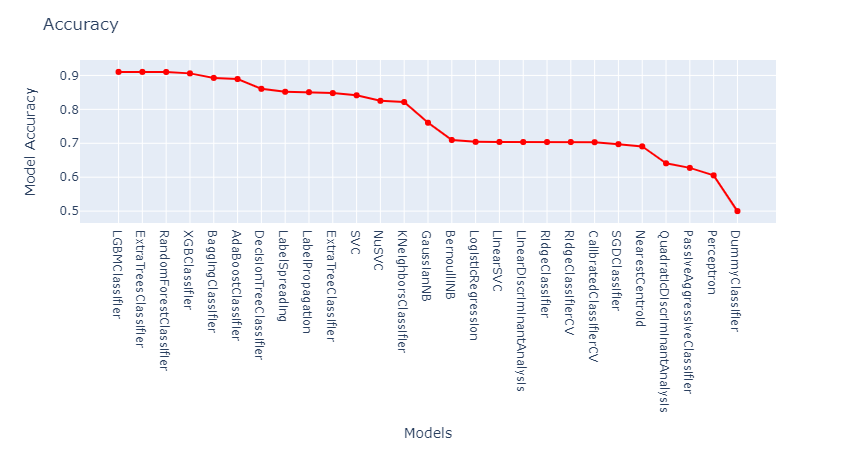

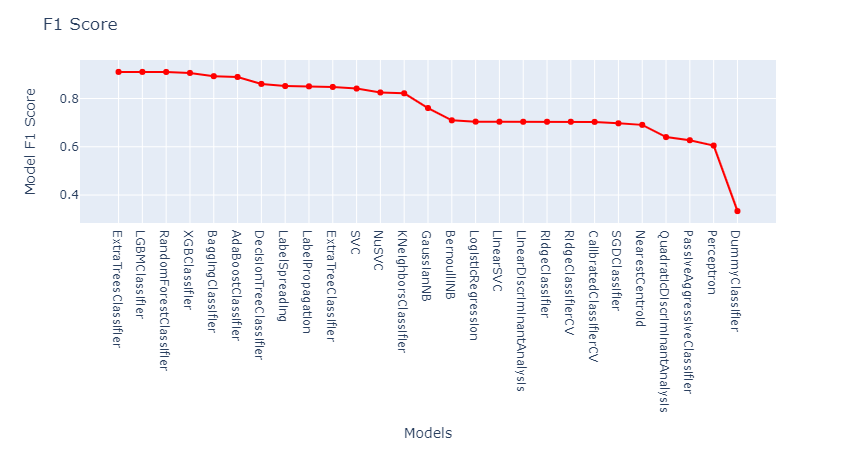

In [34]:
# show the results
index = ['Accuracy','F1 Score']
for i in index:
    results.sort_values(by = i ,inplace = True,ascending = False)
    line = px.line(data_frame= results ,y =i , markers = True)
    line.update_xaxes(title="Models")
    line.update_yaxes(title = f"Model {i}")
    line.update_traces(line_color="red")
    line.update_layout(title = {'text': f'{i} '})
    line.show()

I have built up 10 classification models to fit the bank customer churn data. The four models with the best performance in f1 score and accuracy are all tree-based models. The best is ExtraTreeClassifier, the second is LGBMClassifier, the third is RandomForestClassifier, and the fourth is XGBClassifier. My subsequent model improvements are mainly aimed at tree models. The worst performer is DummyClassifier, obviously the dummy classification is incorrect because the variables are not unique.

### Part4:Model Evaluation

Using features selection for RandomForest

In [53]:
print(X_train)

[[-1.66711799 -1.01024202 -1.01024202 ... -1.6478148   1.16135334
   0.14810244]
 [-0.44828143  0.30797603  0.30797603 ...  0.6922926  -0.96346648
  -0.0615317 ]
 [-2.15249538 -1.01024202 -1.01024202 ... -1.6478148   1.16135334
   0.38413484]
 ...
 [-0.83147827 -1.01024202 -1.01024202 ... -0.97265621  0.54830867
   0.11161012]
 [ 2.00017785  1.62619407  1.62619407 ... -1.6478148  -0.96346648
  -0.97631099]
 [ 1.59030361  0.30797603  0.30797603 ... -1.6478148  -0.96346648
   0.06314198]]


**Using random forest to show features importance**

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2065
           1       0.94      0.88      0.91      2065

    accuracy                           0.91      4130
   macro avg       0.91      0.91      0.91      4130
weighted avg       0.91      0.91      0.91      4130

Accuracy score of Decision Tree:  0.9099273607748184


Text(0.5, 0, 'Random Forest Feature Importance')

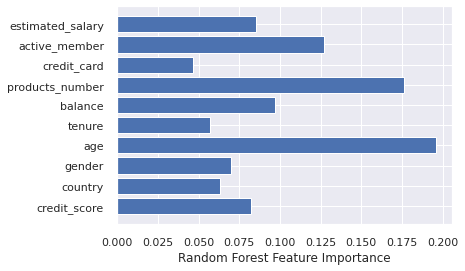

In [54]:
rfc = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, random_state=10)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print(classification_report(y_test,y_pred_rfc,digits=2))
print("Accuracy score of Decision Tree: ", accuracy_score(y_test, y_pred_rfc))
# check the feature importance
rfc.feature_importances_
columns = df.columns
columns = columns[:-1]
plt.barh(columns, rfc.feature_importances_)
plt.xlabel("Random Forest Feature Importance")

In [55]:
# delete feature which feature importance less than 0.025
# delete credit card
X_train = np.delete(X_train,2,axis=1)
X_test = np.delete(X_test,2,axis=1)

In [56]:
# rebuild random forest model
from itertools import product
n_estimators = 100
max_features = [7, 'sqrt', 'log2']
max_depths = [None, 2,3,4,5]
for f, d in product(max_features, max_depths): 
    rfc2 = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=10)
    rfc2.fit(X_train,y_train)
    prediction_test = rfc2.predict(X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    print(cm)

Classification accuracy on test set with max features = 7 and max_depth = None: 0.903
[[1931  134]
 [ 267 1798]]
Classification accuracy on test set with max features = 7 and max_depth = 2: 0.765
[[1824  241]
 [ 728 1337]]
Classification accuracy on test set with max features = 7 and max_depth = 3: 0.809
[[1837  228]
 [ 559 1506]]
Classification accuracy on test set with max features = 7 and max_depth = 4: 0.855
[[1844  221]
 [ 378 1687]]
Classification accuracy on test set with max features = 7 and max_depth = 5: 0.875
[[1910  155]
 [ 363 1702]]
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.908
[[1947  118]
 [ 263 1802]]
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.818
[[1736  329]
 [ 424 1641]]
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.854
[[1842  223]
 [ 382 1683]]
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.870
[[1864  201]
 [ 335

In [57]:
# gridsearch LGBM
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

lgb3= LGBMClassifier(max_depth=None, random_state=10, silent=True, metric='None', n_jobs=4, n_estimators=2000)
parameter ={'num_leaves': sp_randint(20, 100), 
             'min_child_samples': sp_randint(100, 700), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

clf3 =RandomizedSearchCV(lgb3,
                        param_distributions=parameter,
                        n_iter=70,
                        scoring='roc_auc',
                        cv=5,
                        verbose=5,
                       refit=True,
                       random_state=10)

clf3.fit(X_train,y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_lambda=20, subsample=0.3584502918076992;, score=0.962 total time=   1.5s
[CV 2/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_lambda=20, subsample=0.3584502918076992;, score=0.958 total time=   1.4s
[CV 3/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_lambda=20, subsample=0.3584502918076992;, score=0.954 total time=   1.4s
[CV 4/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_lambda=20, subsample=0.3584502918076992;, score=0.961 total time=   1.5s
[CV 5/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_l

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(max_depth=None, metric='None',
                                            n_estimators=2000, n_jobs=4,
                                            random_state=10, silent=True),
                   n_iter=70,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd5f46c7750>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd5f46c70d0>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd5f4929410>,
                            

In [58]:
clf3.best_params_

{'colsample_bytree': 0.9872914874545856,
 'min_child_samples': 559,
 'min_child_weight': 0.001,
 'num_leaves': 57,
 'reg_alpha': 7,
 'reg_lambda': 0.1,
 'subsample': 0.6158375887003041}

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2065
           1       0.94      0.87      0.90      2065

    accuracy                           0.90      4130
   macro avg       0.91      0.90      0.90      4130
weighted avg       0.91      0.90      0.90      4130

Accuracy score of Logistic Regression:  0.9043583535108959


0.9043583535108959

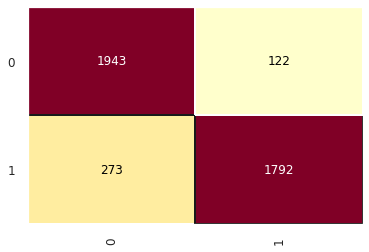

In [59]:
#using best parameters rebuild the model
best_model = clf3.best_estimator_
best_model.fit(X_train,y_train)
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test,y_pred_best,digits=2))
print("Accuracy score of Logistic Regression: ", accuracy_score(y_test, y_pred_best))
cm = ConfusionMatrix(best_model)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)

The result improved than before in part 3.

In [60]:
cm2 = confusion_matrix(y_test, y_pred_best)
# print(cm2)
# calculate sensitive, recall and other index
TP = cm2[1][1]
TN = cm2[0][0]
FP = cm2[0][1]
FN = cm2[1][0]

# True positive rate
pr = TP/(TP+FN)
print ("The True Positive rate is: ",pr)

# Precision
pre = TP/(TP+FP)
print ("The Precision is: ",pre)

# False positive rate
fpr = FP/(FP+TN)
print ("The False Alarm rate is: ",fpr)

# Classification error
error = (FP+FN)/(TP+FP+FN+TN)
print ("The Classification error is", error)

# Overall accuracy
acc = (TP+TN)/(TP+FP+FN+TN)
print ("The Accuracy is", acc)

The True Positive rate is:  0.8677966101694915
The Precision is:  0.9362591431556949
The False Alarm rate is:  0.05907990314769976
The Classification error is 0.09564164648910412
The Accuracy is 0.9043583535108959


Because the data is unbalanced, it is not meaningful to simply consider accuracy. Churn customer analysis, we need to select all true negative users, that is, find as many users as possible with churn classification as 1, so we can pay attention to the precision indicator. precision means the correct result returned by the algorithm divided by all the results returned.

Using balanced accuarcy

In [61]:
# (TPR+TNR)/2
tnr = 1-fpr
tpr = pr
accuracy_balanced = (tnr+tpr)/2
accuracy_balanced

0.9043583535108959

In [62]:
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)

In [63]:
print('Final scores \n')
results = pd.DataFrame(np.array([f1,recall, precision]), columns=['results'], index=['F1 score', 'recall', 'precision'])
print(results)

Final scores 

           results
F1 score      0.90
recall        0.87
precision     0.94


What is the result ,If delete more features.

In [64]:
X_train = np.delete(X_train,4,axis=1)
X_test = np.delete(X_test,4,axis=1)

In [65]:
lgb4= LGBMClassifier(max_depth=None, random_state=10, silent=True, metric='None', n_jobs=4, n_estimators=2000)
parameter ={'num_leaves': sp_randint(20, 100), 
             'min_child_samples': sp_randint(100, 700), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

clf4 =RandomizedSearchCV(lgb4,
                        param_distributions=parameter,
                        n_iter=70,
                        scoring='roc_auc',
                        cv=5,
                        verbose=5,
                       refit=True,
                       random_state=10)

clf4.fit(X_train,y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_lambda=20, subsample=0.3584502918076992;, score=0.960 total time=   1.4s
[CV 2/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_lambda=20, subsample=0.3584502918076992;, score=0.951 total time=   1.4s
[CV 3/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_lambda=20, subsample=0.3584502918076992;, score=0.950 total time=   1.3s
[CV 4/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_lambda=20, subsample=0.3584502918076992;, score=0.957 total time=   2.1s
[CV 5/5] END colsample_bytree=0.8627923859600476, min_child_samples=627, min_child_weight=1e-05, num_leaves=48, reg_alpha=0, reg_l

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(max_depth=None, metric='None',
                                            n_estimators=2000, n_jobs=4,
                                            random_state=10, silent=True),
                   n_iter=70,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd5f404b650>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd5f404b310>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd5f404b290>,
                            

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2065
           1       0.93      0.86      0.90      2065

    accuracy                           0.90      4130
   macro avg       0.90      0.90      0.90      4130
weighted avg       0.90      0.90      0.90      4130

Accuracy score of Logistic Regression:  0.9016949152542373


0.9016949152542373

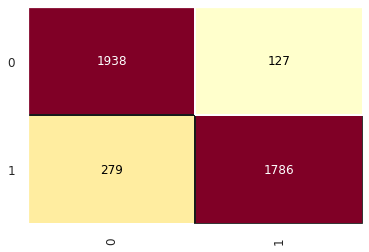

In [66]:
#using best parameters rebuild the model
best_model = clf4.best_estimator_
best_model.fit(X_train,y_train)
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test,y_pred_best,digits=2))
print("Accuracy score of Logistic Regression: ", accuracy_score(y_test, y_pred_best))
cm = ConfusionMatrix(best_model)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)